### **Due Date**
November 7 at 11:59PM EST

### **Writeup**
https://docs.google.com/document/d/1S4Zhtt7gvLwodiac6CVCqYsj0qPz6uJrFLJPRpFv9SA

# **Introduction**

Welcome to Assignment 4 of CS 4756/5756. In this assignment, you will implement several variations of Policy Gradient methods. Concretely, you will:
* Implement the REINFORCE algorithm (Part 1)
* Incorporate Reward-To-Go into the REINFORCE loss function (Part 2)
* Implement the Advantage Actor-Critic algorithm (Part 3, CS 5756 only)

You will use the CartPole-v1 environment for this assignment. Refer to the Gym website for more details about the [CartPole environment](https://www.gymlibrary.dev/environments/classic_control/cart_pole/).


Please read through the following paragraphs carefully.

**Getting Started:** You are free to complete this assignment on **either  [Google Colab](https://colab.research.google.com/) or your local machine**. Note that there will be a small amount of extra setup if you choose to complete the assignment on your local machine (see **Setup** section below).

**Evaluation:**
Your code will be tested for correctness and, for certain assignments, speed. For this particular assignment, performance results will not be harshly graded (although we provide approximate expected reward numbers, you are not expected to replicate them exactly). Please remember that all assignments should be completed individually.

**Academic Integrity:** We will be checking your code against other submissions in the class for logical redundancy. If you copy someone else’s code and submit it with minor changes, we will know. These cheat detectors are quite hard to fool, so please don’t try. We trust you all to submit your own work only; please don’t let us down. If you do, we will pursue the strongest consequences available to us.

**Getting Help:** The [Resources](https://www.cs.cornell.edu/courses/cs4756/2024sp/#resources) section on the course website is your friend! If you ever feel stuck in these projects, please feel free to avail yourself to office hours and Edstem! If you are unable to make any of the office hours listed, please let TAs know and we will be happy to assist. If you need a refresher for PyTorch, please see this [60 minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)! For Numpy, please see the quickstart [here](https://numpy.org/doc/stable/user/quickstart.html) and full API [here](https://numpy.org/doc/stable/reference/).


# **Setup**

As mentioned above, you are free to use Google Colab or your local machine for this assignment. Regardless of your choice, **you will need to run the cell below**. If you are using your local machine, though, you will first need to set up a conda environment that contains the packages found in requirements.txt.


### Setting Up Conda Environment (Local Machine Only)

In order to complete the assignment locally, you will need to install the required libraries. To do this, we will use the package manager [Conda](https://conda.io/projects/conda/en/latest/user-guide/getting-started.html).

* First, create a Conda environment in the terminal with the correct version of python by running: `conda create --name cs4756_a4 python=3.10`
* Next, activate the environment by running: `conda activate cs4756_a4`
* Lastly, install the required libraries by runnning: `pip install -r requirements.txt`

When you run the notebook, make sure to set the Python interpreter and kernel to be the version of python from the `cs4756_a4` environment. If you are using VSCode, you may need to restart after creating the environment in order for `cs4756_a4` to be a visible option that you can select for your kernel.



In [21]:
import sys
USING_COLAB = 'google.colab' in sys.modules

if USING_COLAB:
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !pip install -U colabgymrender
    !pip install -U moviepy==0.2.3.5
    !pip install imageio==2.4.1
    !pip install --upgrade AutoROM
    !AutoROM --accept-license
    !pip install gym[classic_control] > /dev/null 2>&1

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import random

seed = 695

# Setting the seed to ensure reproducability
def reseed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

reseed(seed)

# Visualize Helper Function

Below, we provide the helper function `visualize` for your use. This function will create a visualization of the CartPole environment. If you are using Colab, calling this function will render the visualization within the notebook. If you are using your local machine, this function will instead save a video of the visualization to your current directory (rendering videos in Jupyter Notebooks is not widely supported outside of Colab).

In [22]:
def visualize(algorithm=None, video_name="test"):
    """Visualize a policy network for a given algorithm on a single episode

        Args:
            algorithm (PolicyGradient): Algorithm whose policy network will be rolled out for the episode. If
            no algorithm is passed in, a random policy will be visualized.
            video_name (str): Name for the mp4 file of the episode that will be saved (omit .mp4). Only used
            when running on local machine.
    """

    def get_action(obs):
        if not algorithm:
            return env.action_space.sample()
        else:
            return algorithm.select_action(obs)

    if USING_COLAB:
        from colabgymrender.recorder import Recorder

        directory = './video'
        env = gym.make('CartPole-v1')
        env = Recorder(env, directory)
        obs = env.reset()
        for i in range(500):
            action = get_action(obs)
            obs, reward, done, info = env.step(action)

            if done:
                break

        env.play()
    else:
        import cv2

        video = cv2.VideoWriter(f"{video_name}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 24, (600,400))
        env = gym.make("CartPole-v1")
        obs = env.reset()
        for i in range(500):
            action = get_action(obs)
            obs, reward, done, info = env.step(action)

            if done:
                break

            im = env.render(mode='rgb_array')
            im = im[:,:,::-1]

            video.write(im)

        video.release()
        env.close()
        print(f"Video saved as {video_name}.mp4")

# Introducing CartPole-v1

CartPole-v1 is a classic control problem in the field of reinforcement learning. The task is to balance a pole on a cart by moving the cart left or right. The environment consists of a cart that can move horizontally along a track, and a pole that is attached to the cart by a hinge. The pole can rotate freely around the hinge, and the goal is to keep the pole balanced by moving the cart to keep the pole upright.

The observation space consists of four variables: the horizontal position and velocity of the cart, and the angle and angular velocity of the pole. The action space consists of two discrete actions: move the cart to the left, or move the cart to the right. The episode ends when the pole falls beyond a certain angle, or the cart moves too far from the center.

**Run the cell below to visualize the CartPole-v1 environment:**

In [23]:
visualize()

Video saved as test.mp4


# Part 1: Vanilla REINFORCE

In this assignment, we will implement the REINFORCE algorithm and apply it to CartPole-v1. This algorithm is a popular reinforcement learning algorithm that can be used for both discrete and continuous action spaces.

## Overview

The REINFORCE algorithm uses a neural network to learn a policy that maps states to actions. The algorithm collects a set of trajectories, which are used to update the policy network. Below, we present a brief overview of REINFORCE and the equations behind it. **See MACRL 11.4 for a full description of REINFORCE and derivations for the following equations.**

To start, recall the reinforcement learning objective:
$$ J(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta}}[r(\tau)] $$


The goal of REINFORCE is to maximize $J(\theta)$. As REINFORCE is a policy gradient algorithm, it involves taking the gradient of this objective with respect to the parameters $\theta$ of the policy $\pi_{\theta}$:

$$ \nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta}}[\nabla_θ log \pi_\theta (\tau) r(\tau)] $$

The REINFORCE algorithm approximates this quantity from N trajectories as follows:

$$ \nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \Biggl( \sum_{t=0}^{T-1} \nabla_\theta log \pi_\theta(a_{it}|s_{it})\Biggl) \Biggl(\sum_{t=0}^{T-1} r(s_{it}, a_{it}) \Biggl) $$

**Note:** You will implement a slightly modified version of REINFORCE that uses the total discounted reward (with discount factor $\gamma$) rather than the total reward in order to encourage the agent to prioritize more immediate rewards over those in the distant future:

$$ \nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \sum_{t=0}^{T-1} \nabla_\theta log \pi_\theta(a_{it}|s_{it}) R_i $$

where $R_i$ is the total discounted reward for trajectory $i$:

$$ R_i = \sum_{t=0}^{T-1} \gamma^{t} r(s_{it}, a_{it}) $$


As the goal of REINFORCE is to maximize $J(\theta)$, our loss function $L(\theta)$ (which we will be minimizing) will be the following:

$$ L(\theta) = - \frac{1}{N} \sum_{i=1}^{N} \sum_{t=0}^{T-1} log \pi_\theta(a_{it}|s_{it}) R_i$$


## Instructions

You will need to implement the following:

1. `PolicyNet` class - This class will define the policy network used in the REINFORCE algorithm.

2. `PolicyGradient` class - This class will define the REINFORCE algorithm.


Follow the instructions below to implement each of these components.

### `PolicyNet` class

The `PolicyNet` class should define a neural network that takes in a state and outputs a probability distribution over the action space. The network should have the following architecture:

- Input layer: a fully-connected layer with `state_dim` input nodes and `hidden_dim` output nodes, followed by a ReLU activation function.

- Output layer: a fully-connected layer with `hidden_dim` input nodes and `action_dim` output nodes, followed by a softmax activation function.

You should use the `nn` module of PyTorch to define this network.

In [24]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int):
        """Policy network for the REINFORCE algorithm.

        Args:
            state_dim (int): Dimension of the state space.
            action_dim (int): Dimension of the action space.
            hidden_dim (int): Dimension of the hidden layers.
        """
        super(PolicyNet, self).__init__()
        # TODO: Implement the policy network for the REINFORCE algorithm here
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state: torch.Tensor):
        """Forward pass of the policy network.

        Args:
            state (torch.Tensor): State of the environment.

        Returns:
            x (torch.Tensor): Probabilities of the actions.
        """
        # TODO: Implement the forward pass of the policy network here
        x = torch.relu(self.fc1(state))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x


### `PolicyGradient` class

The `PolicyGradient` class should define the REINFORCE algorithm.
The `PolicyGradient` class should have the following methods:

- `__init__(self, env, policy_net, seed, reward_to_go: bool = False)`: Constructor method that initializes the environment and policy network.

- `select_action(self, state)`: Method that selects an action based on the policy network.

- `compute_loss(self, episode, gamma)`: Method that computes the loss for a given episode.

- `update_policy(self, episodes, optimizer, gamma)`: Method that updates the policy network.

- `train(self, num_iterations, batch_size, gamma, lr)`: Method that trains the policy network using the REINFORCE algorithm.

- `run_episode(self)`: Method that runs an episode of the environment and returns the episode.

- `evaluate(self, num_episodes = 100)`: Method that evaluates the policy network by running multiple episodes.

In [25]:
class PolicyGradient:
    def __init__(self, env, policy_net, seed, reward_to_go: bool = False):
        """Policy gradient algorithm based on the REINFORCE algorithm.

        Args:
            env (gym.Env): Environment
            policy_net (PolicyNet): Policy network
            seed (int): Seed
            reward_to_go (bool): True if using reward_to_go, False if not
        """
        self.env = env
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy_net = policy_net.to(self.device)
        self.reward_to_go = reward_to_go
        self.seed = seed
        self.env.seed(self.seed)
        self.env.action_space.seed(self.seed)
        self.env.observation_space.seed(self.seed)
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)

    def select_action(self, state):
        """Select an action based on the policy network

        Args:
            state (np.ndarray): State of the environment

        Returns:
            action (int): Action to be taken
        """
        # TODO: Implement the action selection here based on the policy network output probabilities
        # Hint: You can use torch.distributions.Categorical to sample from the policy network output distribution
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        action_probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample().item()
        return action

    def compute_loss(self, episode, gamma):
        """Compute the loss function for the REINFORCE algorithm

        Args:
            episode (list): List of tuples (state, action, reward)
            gamma (float): Discount factor

        Returns:
            loss (torch.Tensor): The value of the loss function
        """
        # TODO: Extract states, actions and rewards from the episode
        state,actions,rewards = zip(*episode)
        discounts = [gamma**i for i in range(len(rewards))]
        if not self.reward_to_go:
            # TODO: Part 1: Compute the total discounted reward here
            discounted_rewards = sum([d*r for d,r in zip(discounts,rewards)])
            Rs = [discounted_rewards] * len(rewards)

        else:
            # TODO: Part 2: Compute the discounted rewards to go here
            Rs = []
            for i in range(len(rewards)):
                discounted_rewards = sum([d*r for d,r in zip(discounts[:len(rewards)-i],rewards[i:])])
                Rs.append(discounted_rewards)
        Rs = torch.tensor(Rs,dtype=torch.float32).to(self.device)
        # TODO: Implement the loss function for the REINFORCE algorithm here
        loss = 0
        for log_prob, R in zip([torch.log(self.policy_net(torch.tensor(s,dtype=torch.float32).to(self.device))[a]) for s,a in zip(state,actions)],Rs):
            loss += -log_prob*R
        return loss

    def update_policy(self, episodes, optimizer, gamma):
        """Update the policy network using the batch of episodes

        Args:
            episodes (list): List of episodes
            optimizer (torch.optim): Optimizer
            gamma (float): Discount factor
        """
        # TODO: Compute the loss function for each episode using compute_loss
        optimizer.zero_grad()
        losses = [self.compute_loss(episode,gamma) for episode in episodes]
        loss = torch.stack(losses).mean()
        loss.backward()
        optimizer.step()
        # TODO: Update the policy network using average loss across the batch

    def run_episode(self):
        """
        Run an episode of the environment and return the episode

        Returns:
            episode (list): List of tuples (state, action, reward)
        """
        self.env.seed(seed)
        self.env.action_space.seed(seed)
        self.env.observation_space.seed(seed)
        state = self.env.reset()
        episode = []
        done = False
        while not done:
            action = self.select_action(state)
            next_state, reward, done, info = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
        return episode

    def train(self, num_iterations, batch_size, gamma, lr):
        """Train the policy network using the REINFORCE algorithm

        Args:
            num_iterations (int): Number of iterations to train the policy network
            batch_size (int): Number of episodes per batch
            gamma (float): Discount factor
            lr (float): Learning rate
        """
        self.policy_net.train()
        optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        # TODO: Implement the training loop for the REINFORCE algorithm here. 
        # Update the policy every iteration, and use one batch per iteration.
        rewards = []
        for i in range(1,num_iterations+1):
            episodes = [self.run_episode() for _ in range(batch_size)]
            self.update_policy(episodes,optimizer,gamma)
            if(i%10==0):
                rewards.append(self.evaluate(10))
        return rewards

    def evaluate(self, num_episodes = 100):
        """Evaluate the policy network by running multiple episodes.

        Args:
            num_episodes (int): Number of episodes to run

        Returns:
            average_reward (float): Average total reward per episode
        """
        self.policy_net.eval()
        # TODO: Implement an evaluation loop for the REINFORCE algorithm here
        # by running multiple episodes and returning the average total reward
        total_reward = 0
        with torch.no_grad():
            for _ in range(num_episodes):
                episode = self.run_episode()
                total_reward += sum([r for _,_,r in episode])
        return total_reward/num_episodes

Now that you have implemented REINFORCE, it is time to train and evaluate a policy. Below, we provide training hyperparameters which you should use in your experiments. See the writeup for additional instructions on what metrics and figures you need to include in your submission.

* Expected Training Time (Colab CPU): 5 minutes
* Expected Reward (when calling `evaluate(100)`): 50-100

96.68
Video saved as reinforce.mp4


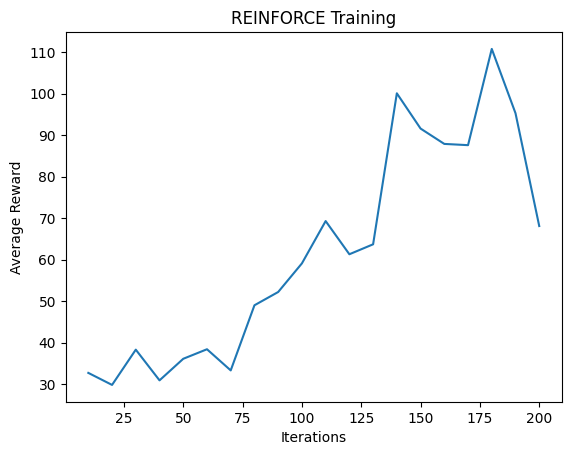

In [26]:
# Feel free to use the space below to run experiments and create plots used in your writeup.
env = gym.make("CartPole-v1")
env.seed(seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)

policy_net = PolicyNet(env.observation_space.shape[0], env.action_space.n, 128)

reinforce = PolicyGradient(env, policy_net, seed, reward_to_go=False)
rewards = reinforce.train(num_iterations=200, batch_size=10, gamma=0.99, lr=0.001)
print(reinforce.evaluate(100))

visualize(algorithm=reinforce, video_name="reinforce")
import matplotlib.pyplot as plt
x = [10*i for i in range(1,21)]
plt.plot(x,rewards)
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("REINFORCE Training")
plt.show()

# Part 2: REINFORCE with Reward-to-Go

In this part of the assignment, we will modify the REINFORCE algorithm to use the (discounted) reward-to-go instead of the total discounted reward.

To decrease the variance of the policy gradient, one approach is to make use of causality by observing that the policy cannot influence past rewards. This results in a revised objective where the total rewards only include those acquired after the policy is evaluated. These rewards are considered a sample estimation of the Q function and are known as the "reward-to-go".

## Overview

The reward-to-go is defined as:

$$ R_t = \sum_{t'=t}^{T-1} \gamma^{t'-t} r(s_{t'}, a_{t'}) $$


The updated policy gradient will look like this (same as before, except discounted reward-to-go instead of discounted total reward):

$$ \nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N}  \sum_{t=0}^{T-1} \nabla_\theta log \pi_\theta(a_{it}|s_{it}) R_{it} $$

Thus, the updated loss function will be:

$$ L(\theta) = - \frac{1}{N} \sum_{i=1}^{N} \sum_{t=0}^{T-1} log \pi_\theta(a_{it}|s_{it}) R_{it}$$




## Instructions

Modify the `compute_loss` method to allow for the use of reward-to-go instead of the total discounted reward.

Now that you have implemented REINFORCE with reward-to-go, it is time to train and evaluate a policy. Below, we provide training hyperparameters which you should use in your experiments. See the writeup for additional instructions on what metrics and figures you need to include in your submission.

* Expected Training Time (Colab CPU): 10 minutes
* Expected Reward (when calling `evaluate(100)`): 200-400

296.79
Video saved as reinforce_rtg.mp4


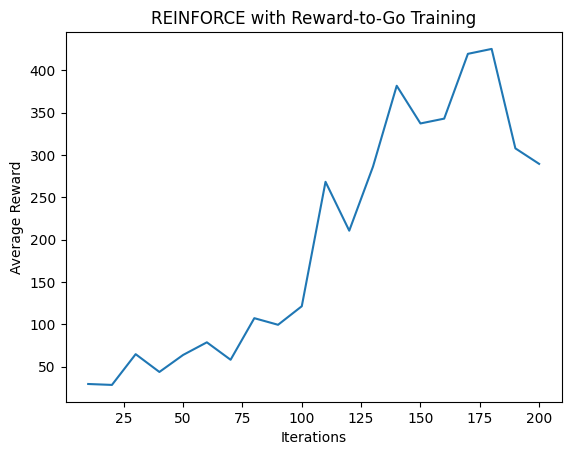

In [27]:
# Feel free to use the space below to run experiments and create plots used in your writeup.
reseed(seed)
env.seed(seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)
env.reset()

policy_net_rtg = PolicyNet(env.observation_space.shape[0], env.action_space.n, 128)

reinforce_rtg = PolicyGradient(env, policy_net_rtg, seed, reward_to_go=True)
rewards = reinforce_rtg.train(num_iterations=200, batch_size=10, gamma=0.99, lr=0.001)

print(reinforce_rtg.evaluate(100))
visualize(algorithm=reinforce_rtg, video_name="reinforce_rtg")
x = [10*i for i in range(1,21)]
plt.plot(x,rewards)
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("REINFORCE with Reward-to-Go Training")
plt.show()

# Part 3: Advantage Actor-Critic (CS 5756 only)

In this part of the assignment, we will implement a version of the Advantage Actor-Critic (A2C) algorithm. This algorithm is an extension to the REINFORCE algorithm, and it combines both value-based and policy-based methods. **See MACRL 11.8 for more information on Actor-Critic methods.**

## Overview

The A2C algorithm reduces the variance of the model by subtracting a baseline from the sum of rewards. This modifies our original objective function as follows:

$$ J(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta}}[r(\tau) - b] $$

where $b$ is the baseline.

In A2C, there is both a policy network $\pi_{\theta}$ (actor network) and a value network $V_ϕ$ (critic network). The policy network is used to select actions, while the value network is used to estimate the value of a state. The value network will be used to compute the baseline $b$ in A2C.

Specifically, using $V_{\phi}(s_t)$ as the baseline, and using (discounted) reward-to-go in place of total reward (as done in part 2), A2C approximates $ \nabla_\theta J(\theta)$ as follows:

$$ \nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N}  \sum_{t=0}^{T-1} \nabla_\theta log \pi_\theta(a_{it}|s_{it}) \bigl(R_{it} - V_ϕ (s_{it}) \bigl) $$

This algorithm is called **Advantage** Actor-Critic because the quantity $R_t - V_ϕ (s_{t})$ is an approximation of what is known as the *advantage function* $A^{\pi_{\theta}}$:

$$A^{\pi_{\theta}}(s_t,a_t) = Q^{\pi_{\theta}}(s_t,a_t) - V^{\pi_{\theta}}(s_t) \approx R_t - V_ϕ (s_t)$$

where $Q^{\pi_{\theta}}(s_t,a_t)$ and $V^{\pi_{\theta}}(s_t)$ are the actual exact Q and value functions for ${\pi_{\theta}}$.

Defining $\tilde{A_t} = R_t - V_ϕ (s_t)$ to be the approximate advantage function, we have:

$$ \nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N}  \sum_{t=0}^{T-1} \nabla_\theta log \pi_\theta(a_{it}|s_{it}) \tilde{A_{it}}$$

For A2C, we have two loss functions: one for the policy network and one for the value network. The policy loss will be defined similarly to the loss in reward-to-go REINFORCE, replacing $R_t$ with $\tilde{A_t}$ and additionally taking the average loss within each episode rather than using total loss (as is commonly done in practice):

$$ L_{\text{policy}} = - \frac{1}{N}\sum_{i=1}^{N} \frac{1}{T}\sum_{t=0}^{T-1} \log \pi_{\theta}(a_{it}|s_{it}) \tilde{A_{it}} $$

The value loss will be the average (across episodes) mean squared error between the reward to go and the estimated value of the state. But note that we already defined the difference between reward to go and estimated value as the approximate advantage function. So we have:

$$ L_{\text{value}} = \frac{1}{N}\sum_{i=1}^{N} \frac{1}{T}\sum_{t=0}^{T} (R_{it} - V_{\phi}(s_{it}))^2 = \frac{1}{N}\sum_{i=1}^{N} \frac{1}{T}\sum_{t=0}^{T} \tilde{A_{it}}^2$$

## Instructions

You will need to implement the following:

1. `ValueNet` class - This class will define the value network used in the A2C algorithm.

2. `ActorCriticPolicyGradient` class - This class will define the A2C algorithm. It will be a modified version of the `PolicyGradient` class that includes the value network and the A2C loss functions.

Follow the instructions below to implement each of these components.

### `ValueNet` class

The `ValueNet` class should define a neural network that takes in a state and outputs an estimate of the value of that state. The network should have the following architecture:

- Input layer: a fully-connected layer with `state_dim` input nodes and `hidden_dim` output nodes, followed by a ReLU activation function.

- Output layer: a fully-connected layer with `hidden_dim` input nodes and 1 output node.

You should use the `nn` module of PyTorch to define this network.

In [28]:
class ValueNet(nn.Module):
    def __init__(self, state_dim: int, hidden_dim: int):
        """Value network for the Actor-Critic algorithm.

        Args:
            state_dim (int): Dimension of the state space.
            hidden_dim (int): Dimension of the hidden layers.
        """
        super(ValueNet, self).__init__()
        # TODO: Implement the value network for the A2C algorithm here
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.Tensor):
        """Forward pass of the value network.

        Args:
            state (torch.Tensor): State of the environment.

        Returns:
            x (torch.Tensor): Estimated value of the state.
        """
        # TODO: Implement the forward pass for the value network here
        x = torch.relu(self.fc1(state))
        x = self.fc2(x)
        return x

### `ActorCriticPolicyGradient` class

The `ActorCriticPolicyGradient` class should define the A2C algorithm.

The `ActorCriticPolicyGradient` class should override the following methods from `PolicyGradient`:

- `__init__(self, env, policy_net: PolicyNet, value_net: ValueNet, reward_to_go: bool = True)`: Constructor method that initializes the environment, policy network, and value network. You can ignore the `reward_to_go` argument here as in A2C we will always be using reward-to-go.

- `compute_loss(self, episode, gamma)`: Method that computes the two loss functions for the A2C algorithm.

- `update_policy(self, episodes, optimizer, gamma)`: Method that updates the policy network and value network using a batch of episodes.

- `train(self, num_episodes, batch_size, gamma, lr)`: Method that trains the policy network and value network using the A2C algorithm.

In [29]:
class ActorCriticPolicyGradient(PolicyGradient):
    def __init__(self, env, policy_net, value_net, seed, reward_to_go: bool = True):
        """A2C algorithm.

        Args:
            env (gym.Env): Environment
            policy_net (PolicyNet): Policy network
            value_net (ValueNet): Value network
            seed (int): Seed
            reward_to_go (bool): Not used
        """
        self.env = env
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy_net = policy_net.to(self.device)
        self.value_net = value_net.to(self.device)
        self.seed = seed
        self.env.seed(self.seed)
        self.env.action_space.seed(self.seed)
        self.env.observation_space.seed(self.seed)
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)

    def compute_loss(self, episode, gamma):
        """Compute the loss function for the A2C algorithm

        Args:
            episode (list): List of tuples (state, action, reward)

        Returns:
            policy_loss (torch.Tensor): Value of policy loss function
            value_loss (torch.Tensor): Value of value loss function
        """
        # TODO: Compute the policy loss and value loss for A2C
        state,actions,rewards = zip(*episode)
        discounts = [gamma**i for i in range(len(rewards))]
        Rs = []
        for i in range(len(rewards)):
            discounted_rewards = sum([d*r for d,r in zip(discounts[:len(rewards)-i],rewards[i:])])
            Rs.append(discounted_rewards)
        Rs = torch.tensor(Rs,dtype=torch.float32).to(self.device)
        policy_loss = 0
        value_loss = 0
        
        for i in range (len(episode)):
            s,a,r = episode[i]
            R = Rs[i]
            log_prob = torch.log(self.policy_net(torch.tensor(s,dtype=torch.float32).to(self.device))[a])
            advantage = R - self.value_net(torch.tensor(s,dtype=torch.float32).to(self.device)).squeeze()
            policy_loss += -log_prob * advantage
            value_loss += advantage**2
        # print(policy_loss,value_loss)
        return policy_loss, value_loss

    def update_policy(self, episodes, optimizer, value_optimizer, gamma):
        """Update the policy network and value network using the batch of episodes

        Args:
            episodes (list): List of episodes
            optimizer (torch.optim): Optimizer for policy network
            value_optimizer (torch.optim): Optimizer for value network
            gamma (float): Discount factor
        """
        # TODO: Compute the policy and value loss for each episode
        policy_loss = 0
        value_loss = 0
        for episode in episodes:
            policy_loss_ep, value_loss_ep = self.compute_loss(episode,gamma)
            # print(policy_loss_ep,value_loss_ep)
            policy_loss += policy_loss_ep
            value_loss += value_loss_ep
        policy_loss /= len(episodes)
        value_loss /= len(episodes)
        # TODO: Update the policy network and value network using average loss across the batch
        optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        optimizer.step()
        
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

    def train(self, num_iterations, batch_size, gamma, lr):
        """Train the policy network and value network using the A2C algorithm

        Args:
            num_iterations (int): Number of iterations to train the policy and value networks
            batch_size (int): Number of episodes per batch
            gamma (float): Discount factor
            lr (float): Learning rate
        """
        self.policy_net.train()
        optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr)
        value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=lr)
        # TODO: Implement the training loop for the A2C algorithm here. 
        # Update the policy and value networks every iteration, and use one
        # batch per iteration.
        rewards = []
        for i in range(1,num_iterations+1):
            episodes = [self.run_episode() for _ in range(batch_size)]
            self.update_policy(episodes,optimizer,value_optimizer,gamma)
            if i % 10 == 0:
                rewards.append(self.evaluate(10))
        return rewards

Now that you have implemented A2C, it is time to train and evaluate a policy. Below, we provide training hyperparameters which you should use in your experiments. See the writeup for additional instructions on what metrics and figures you need to include in your submission.

* Expected Training Time (Colab CPU): 10 minutes
* Expected Reward (when calling `evaluate(100)`): 400-500

Video saved as a2c.mp4
500.0


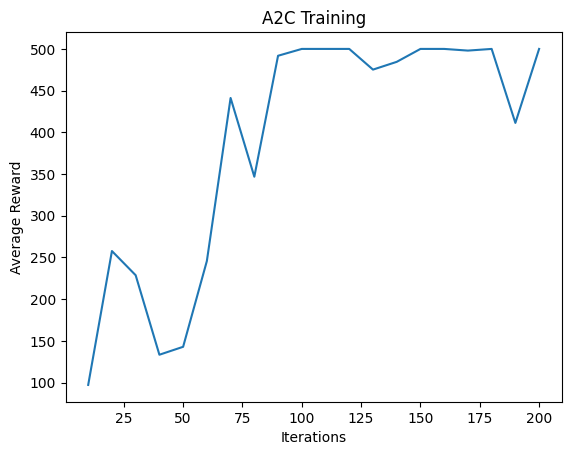

In [30]:
# Feel free to use the space below to run experiments and create plots used in your writeup.
reseed(seed)
env.seed(seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)
env.reset()

policy_net_a2c = PolicyNet(env.observation_space.shape[0], env.action_space.n, 128)
value_net = ValueNet(env.observation_space.shape[0], 128)

a2c = ActorCriticPolicyGradient(env, policy_net_a2c, value_net, seed)
rewards = a2c.train(num_iterations=200, batch_size=10, gamma=0.99, lr=0.01)

visualize(algorithm=a2c, video_name="a2c")
print(a2c.evaluate(100))
x = [10*i for i in range(1,21)]
plt.plot(x,rewards)
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("A2C Training")


plt.show()